# Anomaly Detection with Autoencoders

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

This notebook is referenced in Chapter 25 and 26 in the book.

## Notebook learning goals

At the end of this notebook you will be able to build a simple anomaly detection algorithm using autoencoders with Keras, using `Dense` layers in Keras.

Datasets used:

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset

[fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset 

## Libraries Import

In [2]:
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import time
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow as tf

## MNIST and FASHION MNIST dataset 

For this notebnook we will use two datasets:

- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [Fashion MNIST @ Zalando](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

You can check the two datasets with the links above. They can be easily imported using keras. Below you can see how easy is using [```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [3]:
from keras.datasets import mnist
import numpy as np
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


As usual we will do the typical normalisation of the datasets as you can see below. At this point in the book you should be able to understand the code below easily.

In [4]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

In [5]:
from keras.datasets import fashion_mnist
import numpy as np
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Note that we are doing the same normalisation for the fashion mnist datasets as for the classical MNIST.

In [6]:
fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_train = fashion_x_train.reshape((len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_test = fashion_x_test.reshape((len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))

## Problem to be solved

Now let's create a special dataset that is made of the 10000 images of the MNIST test dataset and **one single** image from the fashion mnist dataset. Our goal in this notebook will be to find this image automatically without looking at them. Can we do it?  

In [7]:
x_test = np.concatenate((mnist_x_test, fashion_x_test[0].reshape(1,784)))
print(x_test.shape)

(10001, 784)


All the images in the MNIST dataset are hand written digits. Below you can see an example of one

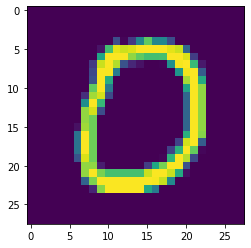

In [10]:
plt.imshow(mnist_x_test[10].reshape(28,28))

But the images in the fashion MNIST are all gray level images of clothing items. In particular the one we are adding to the hand written digits is the image of a show that can be seen below.

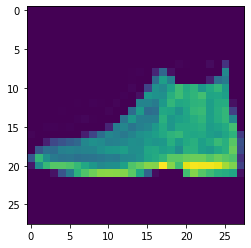

In [9]:
plt.imshow(fashion_x_test[0].reshape(28,28))

## Function to create the autoencoders

Now we need to create the ```keras``` models. An autoencoder is made of two main parts: an _encoder_ and a _decoder_. The function below ```create_autoencoders()``` returns the following parts as separate models:

- The encoder 
- the decoder
- the complete model, when the encoder and decoder are joined in one model.

In [11]:
def create_autoencoders (feature_layer_dim = 16):
  input_img = Input(shape = (784,), name = 'Input_Layer')
  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

## Autoencoder with layers with $(784,64,784)$ neurons.



As a first step let's create an autoencoder with the layer dimensions of $(784, 64, 784)$.




In [46]:
autoencoder, encoder, decoder = create_autoencoders (64)

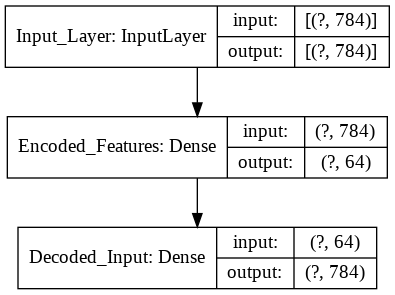

In [47]:
keras.utils.plot_model(autoencoder, show_shapes=True)

As for any keras model we need to compile the model and the fit it to the data. As you can see we don't need any custom code to work with autoencoders. A simple model **definition** $\rightarrow$ **compile** $\rightarrow$ **fit** is enough.

In [48]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [50]:
history = autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_test, mnist_x_test),
                verbose = 0)

In [51]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

We can now calculate the reconstruction error of image $j$ ($\textrm{RE}^{[j]}$) simply calculating

$$
\textrm{RE}^{[j]} = \sum_{i=1}^{784}\frac{(x_i^{[j]}-x_{rec,i}^{[j]})^2}{m}
$$

where $x_i^{[j]}$ is the $i^{th}$ pixel value of the $j$ image, and the sum is over all the pixels.

In [75]:
RE = ((x_test - decoded_imgs)**2).mean(axis=1)

The $\textrm{RE}$ for the image of the shoe we added can be easily printed since it is the last element of the vector ```RE```.

In [62]:
RE[-1]

0.05830472

It is easy to see that this is the highest $\textrm{RE}$ we have for all 10000 images by far. We can check this by sorting the ```RE``` vector.

In [63]:
RE.sort()
print(RE[9990:])

[0.01794755 0.01799489 0.01815483 0.01842355 0.01906578 0.01941952
 0.02057061 0.02083137 0.02164584 0.024418   0.05830472]


You can see that the second highest reconstruction error (0.024418) is less than half of the $\textrm{RE}$ for the added image (0.05830472). Below you can see the original image and the one that the trained autoencoder has reconstructed. You can see how the reconstructed image does not look like the original at all.

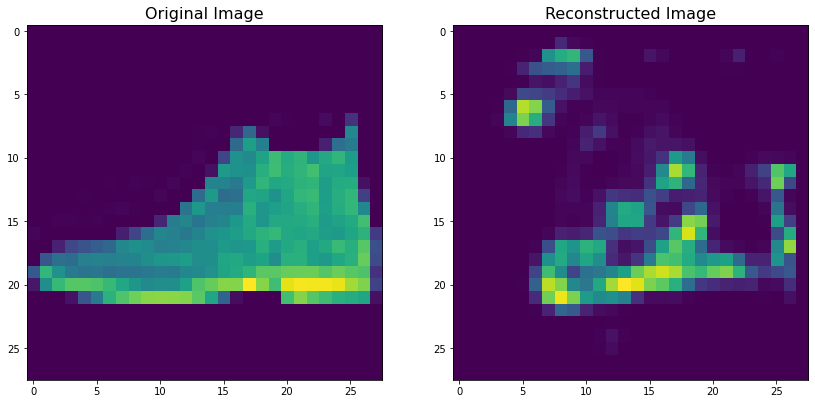

In [73]:
fig = plt.figure(figsize = (14,7))

ax = fig.add_subplot(1, 2, 1)
plt.title("Original Image", fontsize = 16)
plt.imshow(x_test[10000].reshape(28,28))

ax = fig.add_subplot(1, 2, 2)
plt.title("Reconstructed Image", fontsize = 16)
plt.imshow(decoded_imgs[10000].reshape(28,28))

The autoencoder is able to reconstruct perfectly hand-written images, as you can see below.

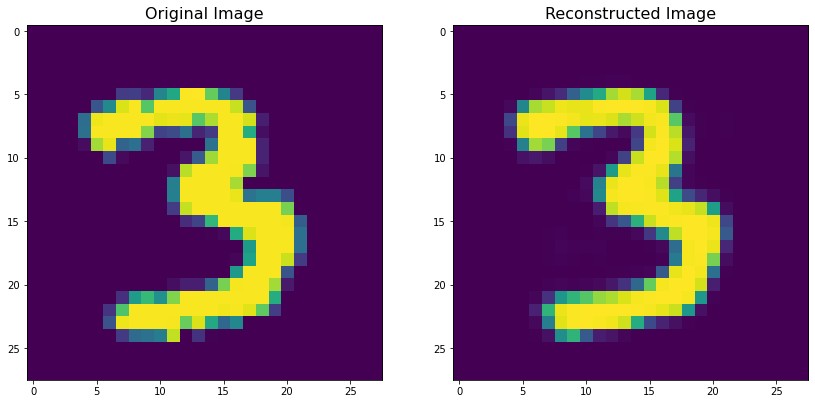

In [74]:
fig = plt.figure(figsize = (14,7))

ax = fig.add_subplot(1, 2, 1)
plt.title("Original Image", fontsize = 16)
plt.imshow(x_test[500].reshape(28,28))

ax = fig.add_subplot(1, 2, 2)
plt.title("Reconstructed Image", fontsize = 16)
plt.imshow(decoded_imgs[500].reshape(28,28))

The image below (and its reconstructed version) of the image with the second highest reconstruction error is show below. The reason is clear, this image does not seems like a hand-written digit at all! That could even count as an outlier in the dataset.

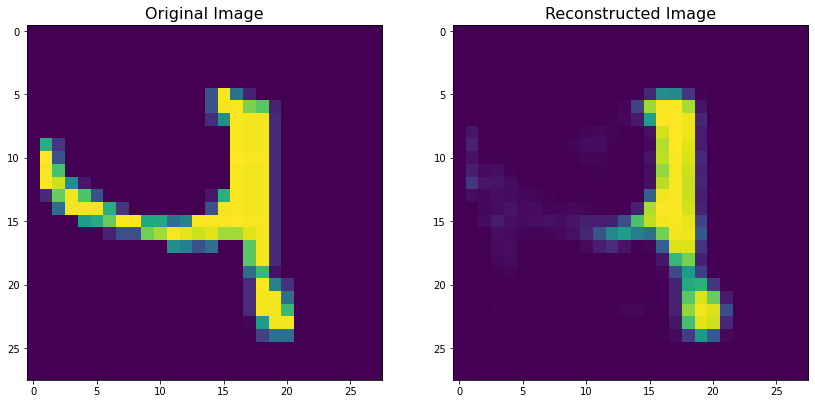

In [84]:
fig = plt.figure(figsize = (14,7))

ax = fig.add_subplot(1, 2, 1)
plt.title("Original Image", fontsize = 16)
plt.imshow(x_test[2836].reshape(28,28))

ax = fig.add_subplot(1, 2, 2)
plt.title("Reconstructed Image", fontsize = 16)
plt.imshow(decoded_imgs[2836].reshape(28,28))